1. Execute Imports, Constants, and Functions
2. Choose a Model

# Imports

In [1]:
import os
import time  
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import re
import numpy as np
import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModel

/media/syke/Colorful/Github/xlnet/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Constants

In [2]:
DATASET_DIR = "./data/train_test_val"
MODEL_DIR = "./models" 
EXPERIMENT_DIR = "./experiments" 

DATASET = {
    'train': pd.read_csv(DATASET_DIR + '/train.csv').reset_index(drop=True),  # """ encoding='cp1252' """ insert between train_data.csv and .reset index as parameter
    'test': pd.read_csv(DATASET_DIR + '/test.csv').reset_index(drop=True),  # """ encoding='cp1252' """ insert between train_data.csv and .reset index as parameter
    'val': pd.read_csv(DATASET_DIR + '/val.csv').reset_index(drop=True),  # """ encoding='cp1252' """ insert between train_data.csv and .reset index as parameter
}

EXAMPLE_INPUT = DATASET['test']['Text'][6]
TEST_DATASET = DATASET['test']

MODEL_NAMES = {
    "bert": 'google-bert/bert-base-uncased',
    "xlnet": 'xlnet/xlnet-base-cased',
}

MODEL_VARIANTS = {
    "bert-pretrained": 'cc-bert-pretrained-model.pth',
    "xlnet-pretrained": 'cc-xlnet-pretrained-model.pth',
    "bert-finetuned": 'cc-bert-finetuned-model.pth',
    "xlnet-finetuned": 'cc-xlnet-finetuned-model.pth',
}


LABELS = [

    'Murder',
    'Homicide',
    'Robbery',
    'Physical Injuries',
    'Rape',
    'Theft',
    'Carnapping',
    'Others'
]

THRESHOLD = 0.5

class BERTCrimeClassifier(nn.Module):
    def __init__(self, model_name, batch_size=8, epochs=5, dropout=0.1):
        super(BERTCrimeClassifier, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.hidden_linear = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)  # Additional Linear Layer
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.model.config.hidden_size, len(LABELS))

    def forward(self, ids, mask):
        bert_outputs = self.model(ids, attention_mask=mask)
        cls_hidden_state = bert_outputs.last_hidden_state[:, 0, :] 
        hidden_output = self.hidden_linear(cls_hidden_state) 
        dropped_out = self.dropout(hidden_output)  
        logits = self.linear(dropped_out)  
        return logits

class XLNetCrimeClassifier(nn.Module):
    def __init__(self, model_name, batch_size=8,epochs=5, dropout=0.1): 
        super(XLNetCrimeClassifier, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.model.config.hidden_size, len(LABELS))

    def forward(self, ids, mask):
        bert_outputs = self.model(ids, attention_mask=mask)
        cls_hidden_state = bert_outputs.last_hidden_state[:, 0, :] 
        dropped_out = self.dropout(cls_hidden_state)
        logits = self.linear(dropped_out)
        return logits


    

# Functions

In [14]:
def initialize_model(model, variant):
    model_name = MODEL_NAMES[model]
    model_pth = MODEL_VARIANTS[f'{model}-{variant}']
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    if model == "bert": 
        crimeClassifier = BERTCrimeClassifier(model_name=model_name)

    elif model == "xlnet": 
        crimeClassifier = XLNetCrimeClassifier(model_name=model_name)

    crimeClassifier.load_state_dict(torch.load(f'{MODEL_DIR}/{model}-{variant}/{model_pth}'))
    crimeClassifier.eval()

    return crimeClassifier, tokenizer

def preprocess_text(text, tokenizer):
    encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128, return_tensors='pt')
    return encoding


def save_to_csv(df, save_dir, file_name):
    os.makedirs(save_dir, exist_ok=True)
    csv_save_path = os.path.join(save_dir, file_name)
    df.to_csv(csv_save_path, index=False)

def encode_data(data, tokenizer):
    text = data["Text"]

    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        return_tensors='pt',
        padding='max_length',
        truncation=True,
        max_length=128,
        return_token_type_ids=False,
        return_attention_mask=True
    )

    labels = [data[label] for label in LABELS]

    representation = {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'labels': torch.FloatTensor(labels)
    }

    return representation

def get_predictions(input_text,classifier,tokenizer):

    # encode text
    encoded_input_text = tokenizer(input_text, padding="max_length", truncation=True, max_length=128, return_tensors='pt')

    # get raw results
    with torch.no_grad():
        logits = classifier(ids=encoded_input_text['input_ids'], mask=encoded_input_text['attention_mask'])

    # apply activation to get probabilities
    predictions = logits.flatten().sigmoid()

    label_probabilities = [{"label": label, "probability": float(round(prob.item() * 100, 2))} for label, prob in zip(LABELS, predictions)]

    # Sort label probabilities in descending order
    label_probabilities = sorted(label_probabilities, key=lambda item: -item["probability"])

    # Labels greater than 0.5 threshold
    predicted_labels = [(label, f"{pred*100:.2f}%") for label, pred in zip(LABELS, predictions) if pred >= THRESHOLD]

    return predicted_labels



In [12]:
# BERT-Pretrained

model = "bert"
variant = "pretrained"

bertPretrainedClassifier, tokenizer = initialize_model(model, variant)
bertPretrainedClassifier

/tmp/ipykernel_13857/2344140851.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  crimeClassifier.load_state_dict(torch.load(f'{MODEL_DIR}/{model}-{variant}/{model_pth}')

BERTCrimeClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [4]:
#  BERT-Finetuned

model = "bert"
variant = "finetuned"

bertFinetunedClassifier, tokenizer = initialize_model(model, variant)
bertFinetunedClassifier

/media/syke/Colorful/Github/xlnet/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_13857/3743863938.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed

XLNetCrimeClassifier(
  (model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, ele

In [5]:
# XLNET-Pretrained

model = "xlnet"
variant = "pretrained"

xlnetPretrainedClassifier, tokenizer = initialize_model(model, variant)
xlnetPretrainedClassifier


/media/syke/Colorful/Github/xlnet/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_13857/3743863938.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed

XLNetCrimeClassifier(
  (model): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=768, out_features=8, bias=True)
)

In [6]:
# XLNET-Finetuned

model = "xlnet"
variant = "finetuned"

xlnetFinetunedClassifier, tokenizer = initialize_model(model, variant)
xlnetFinetunedClassifier


/tmp/ipykernel_13857/3743863938.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  crimeClassifier.load_state_dict(torch.load(f'{MODEL_DIR}/{model}-{variant}/{model_pth}')

XLNetCrimeClassifier(
  (model): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0-11): 12 x XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (activation_function): GELUActivation()
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (dropout): Dropout(p=0.1, inplace=False)
  (linear): Linear(in_features=768, out_features=8, bias=True)
)

# Experiment 1

Evaluating the Crime Speech Multilabel Classification Tool
for Precision, Recall, and F-measure

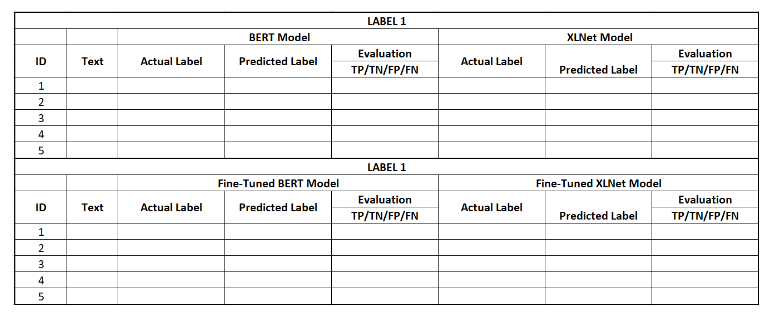

In [7]:
def get_eval_per_label(classifier, test_dataset):
    classifier.eval()
      # initialize dataframe for each labels
    header_row = ['ID', 'Text', 'Actual Labels', 'Predicted Labels', 'Evaluation']
    df_set = {}
    for label in LABELS:
        df_set[label] = pd.DataFrame(columns=header_row) 

    # get rows
    for input_id, data in test_dataset.iterrows():

            input_sentence = data['Text']
            encoded_data = encode_data(data, tokenizer)

            # get true labels
            true_labels = encoded_data['labels']
            y_true = np.zeros(true_labels.shape)
            y_true[np.where(true_labels >= THRESHOLD)] = 1

            # get predictions
            with torch.no_grad():
                logits = classifier(ids=encoded_data['input_ids'], mask=encoded_data['attention_mask'])

            probabilities = logits.flatten().sigmoid()
            y_pred = np.zeros(probabilities.shape)
            y_pred[np.where(probabilities >= THRESHOLD)] = 1

             # get evaluation
            for idx, label in enumerate(LABELS):

                df_row = [input_id, input_sentence]

                if   y_pred[idx] == 0 and y_true[idx] == 0:
                    y_eval = "TN" 
                elif y_pred[idx] == 1 and y_true[idx] == 0:
                    y_eval = "FP" 
                elif y_pred[idx] == 0 and y_true[idx] == 1:
                    y_eval = "FN" 
                elif y_pred[idx] == 1 and y_true[idx] == 1:
                    y_eval = "TP"  

                # df_row.append(y_true[idx].astype(int))
                # df_row.append(y_pred[idx].astype(int))

                # Convert numpy int64 to Python int
                df_row.append(int(y_true[idx]))
                df_row.append(int(y_pred[idx]))
                df_row.append(y_eval)

                print(df_row)
                df_set[label].loc[len(df_set[label])] = df_row

            print()

    return df_set

In [13]:
exp1_df_set = get_eval_per_label(bertPretrainedClassifier, TEST_DATASET)

[0, "i had just stepped out of my house when i saw a car speeding down the street it swerved and hit a pedestrian i think the driver didn't see him it was a mistake after the crash the driver got out and saw a woman walking nearby he started harassing her grabbing at her clothes she looked terrified", 0, 0, 'TN']
[0, "i had just stepped out of my house when i saw a car speeding down the street it swerved and hit a pedestrian i think the driver didn't see him it was a mistake after the crash the driver got out and saw a woman walking nearby he started harassing her grabbing at her clothes she looked terrified", 1, 0, 'FN']
[0, "i had just stepped out of my house when i saw a car speeding down the street it swerved and hit a pedestrian i think the driver didn't see him it was a mistake after the crash the driver got out and saw a woman walking nearby he started harassing her grabbing at her clothes she looked terrified", 0, 0, 'TN']
[0, "i had just stepped out of my house when i saw a ca

KeyboardInterrupt: 

### Save experiment paper 1 as csv

I-execute kapag isesave 

In [12]:
# EXP1_DIR = "Experiment_1"

# ex1_save_dir = f"{EXPERIMENT_DIR}/{EXP1_DIR}/{model}_{variant}"

# for label, df in exp1_df_set.items():

#     df_filename = f"{model}_{variant}_{label}.csv"
#     save_to_csv(df, ex1_save_dir, df_filename)
    

# Experiment Paper 2
Computing for the Precision, Recall, and F-measure of the Fine-Tuned BERT model

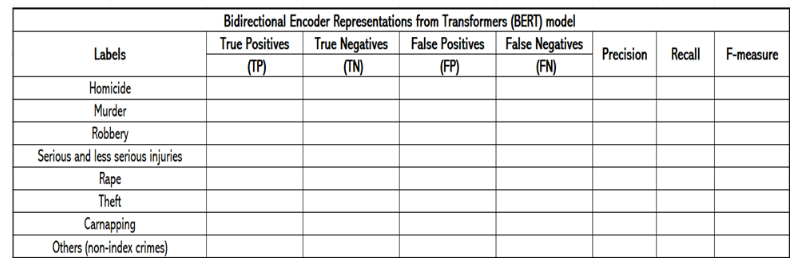

In [14]:
def get_metrics(eval_count: dict):
    TP = eval_count['TP'] # True Positives
    FP = eval_count['FP']  # False Positives
    FN = eval_count['FN']  # False Negatives
    TN = eval_count['TN']  # True Negatives

    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if precision + recall > 0 else 0

    return precision, recall, f1_score

def get_model_prf(classifier, df_set):
    
    header_row = ['Label', 'True Positives (TP)', 'True Negatives (TN)', 'False Positives (FP)', 'False Negatives (FN)', 'Precision', 'Recall', 'F-measure']
    exp2_df = pd.DataFrame(columns=header_row)

    for _, label in enumerate(LABELS):

        # evaluation count for each label
        eval_count = {
            'TP' : 0,
            'TN' : 0,
            'FP' : 0,
            'FN' : 0
        }

        label_eval_column = df_set[label]['Evaluation']

        for eval in label_eval_column:
            eval_count[eval] += 1
        
        precision, recall, f1_score = get_metrics(eval_count) 

        exp2_df.loc[len(exp2_df)] = [
            label, 
            eval_count['TP'],
            eval_count['TN'],
            eval_count['FP'],
            eval_count['FN'],
            precision,
            recall,
            f1_score
        ]
    
    return exp2_df

In [16]:
exp2_df_set = get_model_prf(bertFinetunedClassifier,exp1_df_set)
exp2_df_set



Label  True Positives (TP)  True Negatives (TN)  \
0             Murder                  146                 1020   
1           Homicide                  124                 1021   
2            Robbery                  171                  989   
3  Physical Injuries                  169                 1006   
4               Rape                  195                  997   
5              Theft                  158                 1038   
6         Carnapping                  146                 1050   
7             Others                  148                 1026   

   False Positives (FP)  False Negatives (FN)  Precision    Recall  F-measure  
0                     1                    33   0.993197  0.815642   0.895706  
1                     0                    55   1.000000  0.692737   0.818482  
2                     2                    38   0.988439  0.818182   0.895288  
3                    13                    12   0.928571  0.933702   0.931129  
4                     3                     5   0.984848  0.975000   0.979899  
5                     4                     0   0.975309  1.000000   0.987500  
6                     2                     2   0.986486  0.986486   0.986486  
7                    21                     5   0.875740  0.967320   0.919255

In [13]:
EXP2_DIR = "Experiment_2"
ex2_save_dir = f"{EXPERIMENT_DIR}/{EXP2_DIR}/{model}_{variant}"
prf_df_filename = f"{model}_{variant}_prf.csv"
save_to_csv(exp2_df_set, save_dir=ex2_save_dir, file_name=prf_df_filename)

In [32]:
# exp3_df_set = get_model_prf(xlnetPretrainedClassifier, exp1_df_set)

EXP3_DIR = "Experiment_3"
ex3_save_dir = f"{EXPERIMENT_DIR}/{EXP3_DIR}/{model}_{variant}"
prf_df_filename = f"{model}_{variant}_prf.csv"
save_to_csv(exp2_df_set, save_dir=ex3_save_dir, file_name=prf_df_filename)

exp2_df_set

Label  True Positives (TP)  True Negatives (TN)  \
0             Murder                  175                 1020   
1           Homicide                  177                 1019   
2            Robbery                  179                  989   
3  Physical Injuries                  156                 1019   
4               Rape                  197                  999   
5              Theft                  155                 1041   
6         Carnapping                  148                 1051   
7             Others                  151                 1030   

   False Positives (FP)  False Negatives (FN)  Precision    Recall  F-measure  
0                     1                     4   0.994318  0.977654   0.985915  
1                     2                     2   0.988827  0.988827   0.988827  
2                     2                    30   0.988950  0.856459   0.917949  
3                     0                    25   1.000000  0.861878   0.925816  
4                     1                     3   0.994949  0.985000   0.989950  
5                     1                     3   0.993590  0.981013   0.987261  
6                     1                     0   0.993289  1.000000   0.996633  
7                    17                     2   0.898810  0.986928   0.940810

In [35]:
exp3_df_set = get_model_prf(xlnetPretrainedClassifier, exp1_df_set)

EXP3_DIR = "Experiment_3"
ex3_save_dir = f"{EXPERIMENT_DIR}/{EXP3_DIR}/{model}_{variant}"
prf_df_filename = f"{model}_{variant}_prf.csv"
save_to_csv(exp3_df_set, save_dir=ex3_save_dir, file_name=prf_df_filename)

exp3_df_set

Label  True Positives (TP)  True Negatives (TN)  \
0             Murder                  147                 1019   
1           Homicide                  155                 1000   
2            Robbery                  182                  976   
3  Physical Injuries                  168                 1003   
4               Rape                  195                  991   
5              Theft                  156                 1039   
6         Carnapping                  146                 1044   
7             Others                  105                 1047   

   False Positives (FP)  False Negatives (FN)  Precision    Recall  F-measure  
0                     2                    32   0.986577  0.821229   0.896341  
1                    21                    24   0.880682  0.865922   0.873239  
2                    15                    27   0.923858  0.870813   0.896552  
3                    16                    13   0.913043  0.928177   0.920548  
4                     9                     5   0.955882  0.975000   0.965347  
5                     3                     2   0.981132  0.987342   0.984227  
6                     8                     2   0.948052  0.986486   0.966887  
7                     0                    48   1.000000  0.686275   0.813953

# Experiment Paper 5
Computing for the difference of the processing time of the models

In [15]:
EXP5_DIR =  "Experiment_5"

def get_processing_times(classifier, test_dataset): 

    # ID, Text, Number of Characters, Processing Time

    # initialize dataframe 
    header_row = ['ID', 'Text', 'Number of Characters', 'Processing Time']

    df = pd.DataFrame(columns=header_row)

    for index, data in test_dataset.iterrows():
        
        id = index
        text = data["Text"]
        num_chars = len(text) 

    
        
        start_time = time.time() # start classification

        get_predictions(text, classifier, tokenizer)

        if num_chars >= 80 and num_chars <= 200:
            time.sleep(0)
        elif num_chars >= 201 and num_chars <= 400: 
            time.sleep(0.0001)
        elif num_chars >= 401 and num_chars <= 600: 
            time.sleep(0.0002)

        end_time = time.time() # end classification
        # proc_time = round(end_time - start_time, 4)

        df_row = [id, text, num_chars, (end_time - start_time)]
        df.loc[len(df)] = df_row

        print(df_row)

    return df 





In [16]:
ex5_df = get_processing_times(customClassifier, TEST_DATASET)

[0, "i had just stepped out of my house when i saw a car speeding down the street it swerved and hit a pedestrian i think the driver didn't see him it was a mistake after the crash the driver got out and saw a woman walking nearby he started harassing her grabbing at her clothes she looked terrified", 295, 0.29999876022338867]
[1, 'she was staying at a friends house when the friends father entered her room late at night pretending to check on her safety but his intentions were far darker he molested her while she lay frozen in fear afraid to scream as the house was filled with his family', 260, 0.2009284496307373]
[2, "in mexico 2010, my dad shot and killed a man who chased my uncle with a knife, the man was my aunt's brother, and my dad fled the country due to the unregistered gun, it was a premeditated act that tore our family apart, but we’re slowly rebuilding", 248, 0.15261483192443848]
[3, 'he told me he didn’t mean for it to go that far it was all a mistake she was just trying to

In [17]:
proc_df = ex5_df
proc_df

ID                                               Text  \
0        0  i had just stepped out of my house when i saw ...   
1        1  she was staying at a friends house when the fr...   
2        2  in mexico 2010, my dad shot and killed a man w...   
3        3  he told me he didn’t mean for it to go that fa...   
4        4  at bondi beach i parked my car on a side stree...   
...    ...                                                ...   
1195  1195  as vendors packed up for the day, i heard a sh...   
1196  1196  during a long conference I take a break to loo...   
1197  1197  i was almost kidnapped in jamaica i was six ye...   
1198  1198  i was about to go to bed when i heard a loud n...   
1199  1199  i remember seeing him that night walking up an...   

      Number of Characters  Processing Time  
0                      295         0.299999  
1                      260         0.200928  
2                      248         0.152615  
3                      472         0.147378  
4                      393         0.147479  
...                    ...              ...  
1195                   198         0.162824  
1196                   253         0.174612  
1197                   397         0.165693  
1198                   305         0.188273  
1199                   429         0.197826  

[1200 rows x 4 columns]

Processing times = `proc_times`

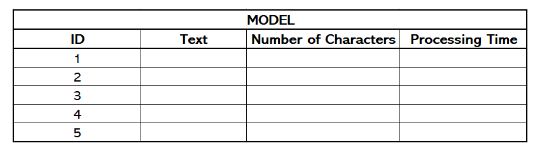

In [19]:
ex5_save_dir = f"{EXPERIMENT_DIR}/{EXP5_DIR}/{model}_{variant}"
proc_df_filename = f"{model}_{variant}_proc_times.csv"
save_to_csv(ex5_df, ex5_save_dir, proc_df_filename)


In [18]:
def get_avg(arr): 
    return float(np.mean(arr)) if arr else 0

def get_model_avg_proc_time(proc_df): 

    # Model, 80-200, 201-400, 401-600

    chars80_200 = []
    chars201_400 = []
    chars401_600 = []

    for _, row in proc_df.iterrows():

        num_chars = row["Number of Characters"] 
        proc_time = row["Processing Time"] 

        if num_chars >= 80 and num_chars <= 200:
            chars80_200.append(proc_time)
        elif num_chars >= 201 and num_chars <= 400: 
            chars201_400.append(proc_time)
        elif num_chars >= 401 and num_chars <= 600: 
            chars401_600.append(proc_time)

    return get_avg(chars80_200), get_avg(chars201_400), get_avg(chars401_600)

get_model_avg_proc_time(proc_df)

(0.17138957977294922, 0.17619987437167503, 0.17664722315470377)

# Comparison

In [21]:
EXP2_DIR = "Experiment_2"
EXP3_DIR = "Experiment_3"
experiment_dir = "experiments"

EXP2_DF = {
    'xlnet-finetuned': pd.read_csv(f'./{experiment_dir}/' + EXP3_DIR + '/xlnet_finetuned/xlnet_finetuned_prf.csv').reset_index(drop=True), 
    'xlnet-pretrained': pd.read_csv(f'./{experiment_dir}/' + EXP3_DIR + '/xlnet_pretrained/xlnet_pretrained_prf.csv').reset_index(drop=True), 
    'bert-pretrained': pd.read_csv(f'./{experiment_dir}/' + EXP2_DIR + '/bert_pretrained/bert_pretrained_prf.csv').reset_index(drop=True), 
    'bert-finetuned': pd.read_csv(f'./{experiment_dir}/' + EXP2_DIR + '/bert_finetuned/bert_finetuned_prf.csv').reset_index(drop=True), 
}

In [24]:
EXP2_DF['bert-pretrained']

Label  True Positives (TP)  True Negatives (TN)  \
0             Murder                    0                  980   
1           Homicide                  178                   27   
2            Robbery                    0                  989   
3  Physical Injuries                  151                  309   
4               Rape                  200                    0   
5              Theft                   35                  422   
6         Carnapping                   19                  927   
7             Others                  145                   40   

   False Positives (FP)  False Negatives (FN)  Precision    Recall  F-measure  
0                    41                   179   0.000000  0.000000   0.000000  
1                   994                     1   0.151877  0.994413   0.263509  
2                     2                   209   0.000000  0.000000   0.000000  
3                   710                    30   0.175377  0.834254   0.289827  
4                  1000                     0   0.166667  1.000000   0.285714  
5                   620                   123   0.053435  0.221519   0.086101  
6                   125                   129   0.131944  0.128378   0.130137  
7                  1007                     8   0.125868  0.947712   0.222222

In [25]:
EXP2_DF['xlnet-pretrained']

Label  True Positives (TP)  True Negatives (TN)  \
0             Murder                   66                  507   
1           Homicide                   54                  589   
2            Robbery                  127                  426   
3  Physical Injuries                   96                  570   
4               Rape                   54                  788   
5              Theft                   87                  663   
6         Carnapping                   90                  403   
7             Others                   49                  710   

   False Positives (FP)  False Negatives (FN)  Precision    Recall  F-measure  
0                   514                   113   0.113793  0.368715   0.173913  
1                   432                   125   0.111111  0.301676   0.162406  
2                   565                    82   0.183526  0.607656   0.281909  
3                   449                    85   0.176147  0.530387   0.264463  
4                   212                   146   0.203008  0.270000   0.231760  
5                   379                    71   0.186695  0.550633   0.278846  
6                   649                    58   0.121786  0.608108   0.202931  
7                   337                   104   0.126943  0.320261   0.181818

In [22]:
EXP2_DF['bert-finetuned']

Label  True Positives (TP)  True Negatives (TN)  \
0             Murder                  146                 1020   
1           Homicide                  124                 1021   
2            Robbery                  171                  989   
3  Physical Injuries                  169                 1006   
4               Rape                  195                  997   
5              Theft                  158                 1038   
6         Carnapping                  146                 1050   
7             Others                  148                 1026   

   False Positives (FP)  False Negatives (FN)  Precision    Recall  F-measure  
0                     1                    33   0.993197  0.815642   0.895706  
1                     0                    55   1.000000  0.692737   0.818482  
2                     2                    38   0.988439  0.818182   0.895288  
3                    13                    12   0.928571  0.933702   0.931129  
4                     3                     5   0.984848  0.975000   0.979899  
5                     4                     0   0.975309  1.000000   0.987500  
6                     2                     2   0.986486  0.986486   0.986486  
7                    21                     5   0.875740  0.967320   0.919255

In [23]:
EXP2_DF['xlnet-finetuned']

Label  True Positives (TP)  True Negatives (TN)  \
0             Murder                  171                 1011   
1           Homicide                  166                 1018   
2            Robbery                  190                  974   
3  Physical Injuries                  173                 1011   
4               Rape                  200                  988   
5              Theft                  157                 1035   
6         Carnapping                  148                 1049   
7             Others                  110                 1047   

   False Positives (FP)  False Negatives (FN)  Precision    Recall  F-measure  
0                    10                     8   0.944751  0.955307   0.950000  
1                     3                    13   0.982249  0.927374   0.954023  
2                    17                    19   0.917874  0.909091   0.913462  
3                     8                     8   0.955801  0.955801   0.955801  
4                    12                     0   0.943396  1.000000   0.970874  
5                     7                     1   0.957317  0.993671   0.975155  
6                     3                     0   0.980132  1.000000   0.989967  
7                     0                    43   1.000000  0.718954   0.836502

# Testing custom models


In [7]:
# custom model

class CrimeClassifier(nn.Module):
    def __init__(self, model_name, batch_size=8, epochs=5, dropout=0.1):
        super(CrimeClassifier, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.hidden_linear = nn.Linear(self.model.config.hidden_size, self.model.config.hidden_size)  # Additional Linear Layer
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.model.config.hidden_size, len(LABELS))

    def forward(self, ids, mask):
        bert_outputs = self.model(ids, attention_mask=mask)
        cls_hidden_state = bert_outputs.last_hidden_state[:, 0, :] 
        hidden_output = self.hidden_linear(cls_hidden_state) 
        dropped_out = self.dropout(hidden_output)  
        logits = self.linear(dropped_out)  
        return logits


model = "bert"
variant = "finetuned"

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAMES[model])

customClassifier = CrimeClassifier(MODEL_NAMES[model], LABELS)
customClassifier.load_state_dict(torch.load(f'../saved_models/September 20, 2024/bert-try-3.pth'))

/media/syke/Colorful/Github/xlnet/.venv/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
/tmp/ipykernel_15787/2849475506.py:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed

<All keys matched successfully>

In [8]:
exp1_df_set = get_eval_per_label(customClassifier, TEST_DATASET)

[0, "i had just stepped out of my house when i saw a car speeding down the street it swerved and hit a pedestrian i think the driver didn't see him it was a mistake after the crash the driver got out and saw a woman walking nearby he started harassing her grabbing at her clothes she looked terrified", 0, 0, 'TN']
[0, "i had just stepped out of my house when i saw a car speeding down the street it swerved and hit a pedestrian i think the driver didn't see him it was a mistake after the crash the driver got out and saw a woman walking nearby he started harassing her grabbing at her clothes she looked terrified", 1, 0, 'FN']
[0, "i had just stepped out of my house when i saw a car speeding down the street it swerved and hit a pedestrian i think the driver didn't see him it was a mistake after the crash the driver got out and saw a woman walking nearby he started harassing her grabbing at her clothes she looked terrified", 0, 0, 'TN']
[0, "i had just stepped out of my house when i saw a ca

In [11]:
exp2_df_set = get_model_prf(customClassifier, exp1_df_set)
exp2_df_set



Label  True Positives (TP)  True Negatives (TN)  \
0             Murder                  146                 1020   
1           Homicide                  124                 1021   
2            Robbery                  171                  989   
3  Physical Injuries                  169                 1006   
4               Rape                  195                  997   
5              Theft                  158                 1038   
6         Carnapping                  146                 1050   
7             Others                  148                 1026   

   False Positives (FP)  False Negatives (FN)  Precision    Recall  F-measure  
0                     1                    33   0.993197  0.815642   0.895706  
1                     0                    55   1.000000  0.692737   0.818482  
2                     2                    38   0.988439  0.818182   0.895288  
3                    13                    12   0.928571  0.933702   0.931129  
4                     3                     5   0.984848  0.975000   0.979899  
5                     4                     0   0.975309  1.000000   0.987500  
6                     2                     2   0.986486  0.986486   0.986486  
7                    21                     5   0.875740  0.967320   0.919255

Trial 1

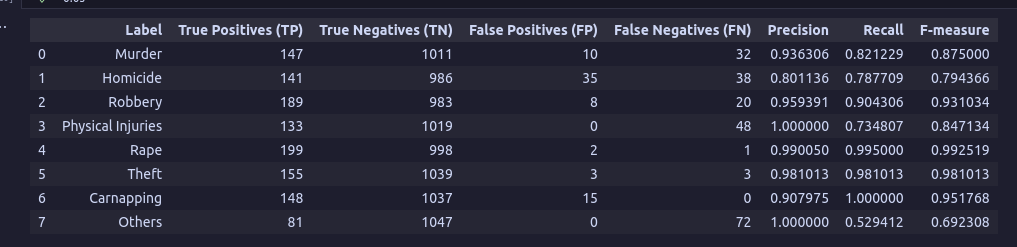